In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from PIL import Image
import tensorflow as tf
import skimage

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.preprocessing import image

In [3]:
from skimage.segmentation import quickshift
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.linear_model import LinearRegression


In [4]:
img_width, img_height = 299, 299
inceptionV3_model =tf.keras.applications.inception_v3.InceptionV3()
img_path = 'sampleimg.png'
img = image.load_img(img_path, target_size=(img_width, img_height))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

[('n02099712', 'Labrador_retriever', 0.75885326), ('n02093428', 'American_Staffordshire_terrier', 0.025036748), ('n02108422', 'bull_mastiff', 0.012021404), ('n02099601', 'golden_retriever', 0.010576082), ('n02109047', 'Great_Dane', 0.009483305)]


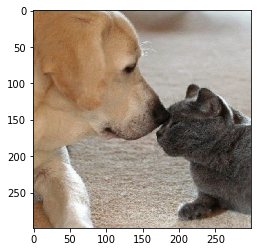

In [5]:
preds = inceptionV3_model.predict(img_data)
predicts=decode_predictions(preds)[0] 
top_pred_classes = preds[0].argsort()[-5:][::-1] 
print(predicts)
plt.imshow(img)

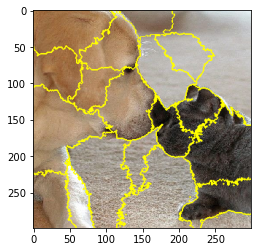

In [6]:
segments_quick = quickshift(img, kernel_size=10, max_dist=10, ratio=0.5)
plt.imshow(mark_boundaries(img, segments_quick))

In [7]:
uni_superpixel=np.unique(segments_quick)
num_pixel=uni_superpixel.shape
num_perturbations=150

In [8]:
uni_array=np.random.binomial(1,0.5,(150,num_pixel[0]))
uni_array=np.array(uni_array)

In [9]:
pro_img=[]
pro_img1=[]
for b in range(150): 
    z=uni_array[b]*uni_superpixel
    unit_arr=np.ones((299,299,3))
    for a in z:
        y=np.where(segments_quick==a,0,1)
        unit_arr[:,:,0]=np.multiply(y,unit_arr[:,:,0])
        unit_arr[:,:,1]=np.multiply(y,unit_arr[:,:,1])
        unit_arr[:,:,2]=np.multiply(y,unit_arr[:,:,2])
    data=image.img_to_array(img)*unit_arr
    pro_img.append(data)
    data = np.expand_dims(data, axis=0)
    pro_img1.append(data)


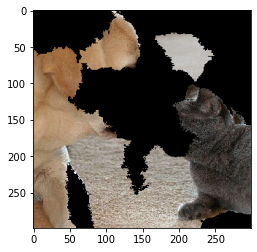

In [10]:
img_f=tf.keras.preprocessing.image.array_to_img(pro_img[0])
plt.imshow(img_f)

In [11]:
predictions_result = []
for i in range(num_perturbations):
    pred = inceptionV3_model.predict(pro_img1[i])
    predictions_result.append(pred)

predictions_result = np.array(predictions_result)
print(predictions_result.shape)

(150, 1, 1000)


In [12]:
unit_array=np.ones(num_pixel[0])[np.newaxis,:]
distances = pairwise_distances(uni_array,unit_array,metric='cosine').ravel()


In [13]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))

In [14]:
class_to_explain = top_pred_classes[0] 
simpler_model = LinearRegression()
simpler_model.fit(uni_array, predictions_result[:,:,class_to_explain], weights)
coeff = simpler_model.coef_[0]
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

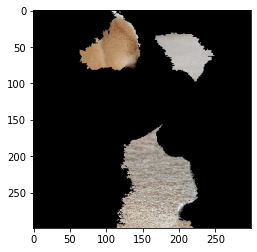

In [15]:
img_data=image.img_to_array(img)
img_data1=img_data
for a in top_features:
    for i in range(0,299):
        for j in range (0,299):
            if segments_quick[i][j]==a:
                img_data1[i][j]=0
img_data=image.img_to_array(img)
img_finaldata=img_data-img_data1
img_final=tf.keras.preprocessing.image.array_to_img(img_finaldata)
plt.imshow(img_final)